# Reservoir Dynamics Modeling

This is the first and core part of modeling water infrastructure as an optimization problem, where we model the natural water dynamics (percipitation, evaporation, overflow, etc.) of a particular reservoir using various metereological, bathymetric, etc. data.


### Google Colab only: install special dependencies

By default, Google Colab has installed NumPy, SciPy, Pandas, etc. However, for our optimization modeling, we need to explicitly install the modeling language [Pyomo](http://www.pyomo.org/) and non-linear solver [IPOPT](https://coin-or.github.io/Ipopt/).

> Do not install these if you have already installed `requirements.txt` for local execution.

Uncomment the following block to install these. You will need to do this for each new session.


In [2]:
# !pip install pyomo
# !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
# !unzip -o -q ipopt-linux64

## Imports


In [3]:
from pyomo.environ import (
    SolverFactory,
    AbstractModel,
    Param,
    RangeSet,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeIntegers, PositiveReals, NonNegativeReals, Reals  # type: ignore

import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots as _

plt.style.use("ieee")

solver = SolverFactory("ipopt")
solver.options["max_iter"] = 10000  # Increase for larger models, if necessary

# Optimization Modeling

> This is a quick summary from a larger draft written by Abhiroop Chattopadhyay (not shown) and thus may be out-of-date. [Email him](ac33@illinois.edu) for more details.

We use a multi-period model where the set $\mathcal K = \{0, 1, 2, \dots, N - 1\}$ denotes a set of $N$ periods.

For a period $k \in \mathcal K$:

- Let $s(k)$ and $a(k)$ denote the storage/volume and area of the reservoir **at the start of the period**.
- Let $r(k)$, $e(k)$, $q(k)$ denote the preciptation inflow, loss by evaporation, and pumping outflow **over the period**.

1. We can model the reservoir storage dynamics as a linear volumetric balance formulation.

$$v(k + 1) = s(k) + r(k) - e(k) - q(k)$$

2. Reservoir overflow occurs when the inflow $r(k)$ causes the reservoir to reach its maximum volume $S$, i.e. when $v(k + 1) > S$. Let the following denote the non-negative overflow voume **over the period**:

$$w(k) = \text{max}\{v(k + 1) - S, 0\}$$

3. We derive the true storage state of the reservoir $s(k + 1)$ as the difference between the "theoretical" volume and overflow: $s(k + 1) = v(k + 1) - w(k)$.

4. We establish a power-law relationship between area $a(k)$ and volume $s(k)$, which enables us to estimate one off the other. We derive the coefficients $\gamma_1$ and $\gamma_2$ from a regression analysis on similar reservoirs (not shown).

$$s(k) = \gamma_1 a(k)^{\gamma_2}$$

> For a fully-linear model, this can alternatively be $s(k) = \frac SA \cdot A(k)$.

5. We upper-bound the surface area $a(k)$ to a maximum $A$: $a(k) \leq A$.

6. We estimate rainfall inflow $r(k)$ **over the period** as the product of the percepitation rate $p(k)$ and the catchment area $A_c$ with an infilitration coefficient $C_i$: $r(k) = C_i A_c p(k)$.

7. Similarly, we estimate the evaporation $e(k)$ **over a period** as the product of the evaporation depth $e_p(k)$ and average surface area with the evaporation pan coefficient $C_p$:

$$e(k) = \left(\frac{a(k + 1) + a(k)}2\right) \cdot C_p e_p(k)$$

8. Finally, we upper-bound the pumping rate $q(k)$ to a maximum $Q$: $q(k) \leq Q$.

9. We define the objective minimization function as the total overflow across all periods:

$$\text{min} \sum_k w(k)$$

## Bounding Overflow

Pyomo does not support binary decision variables/computations, so we cannot directly encode our original $\text{max}$ formulation for $w(k)$. Instead, we simulate this by introducing an unbounded nonphysical overflow $w_u$ that can be negative, i.e. when $v(t + 1) < S$.

$$
\begin{align*}
    w_u(t)
    &= v(t + 1) - S \\
    w(t)
    &= \text{max}(0, w_u(t)) \\
    &= \frac{w_u + |w_u|}2
\end{align*}
$$


In [57]:
# TODO: Change t to k, fix mutability warnings
mu = 1e-6

model = AbstractModel()

# Set `K` of period indices
model.num_periods = Param(within=NonNegativeIntegers)
model.T_periods = RangeSet(0, model.num_periods - 1)
model.T_points = RangeSet(0, model.num_periods)

# Constant parameters
model.c1 = Param(within=PositiveReals)  # Scalar constant c1 for volume
model.c2 = Param(within=PositiveReals)  # Scalar constant c2 for volume
model.A_c = Param(within=PositiveReals)  # Catchment area
model.A_max = Param(within=PositiveReals)  # Maximum surface area
model.Q_max = Param(within=NonNegativeReals)  # Maximum pumping rate
model.E_coeff = Param(within=PositiveReals)  # Evaporation coefficient

# Time-varying parameters
model.P = Param(model.T_periods, within=NonNegativeReals)  # Precipitation rate
model.E_pan = Param(model.T_periods, within=NonNegativeReals)  # Pan evaporation rate

# Time-invariant parameters
model.S_max = Param(
    initialize=model.c1 * (mu + model.A_max) ** model.c2
)  # Maximum storage capacity
model.R = Param(
    model.T_periods,
    default=lambda model, t: model.A_c * model.P[t],
    within=NonNegativeReals,
)  # Calculate rainfall [6]

# Optimizable variables
model.V = Var(model.T_points, domain=NonNegativeReals)  # Volume
model.S = Var(model.T_points, domain=NonNegativeReals)  # Storage
model.A = Var(model.T_points, domain=NonNegativeReals)  # Surface area
model.E = Var(model.T_periods, domain=NonNegativeReals)  # Evaporation
model.Q = Var(model.T_periods, domain=NonNegativeReals)  # Pumping
model.W = Var(model.T_periods, domain=NonNegativeReals)  # Overflow

model.unbounded_W = Var(model.T_periods, domain=Reals)  # Possibly negative overflow

# Objective
model.min_overflow = Objective(
    expr=lambda model: sum(model.W[t] for t in model.T_periods)
)  # Minimize overflow

# Constraints
model.volume = Constraint(
    model.T_periods,
    rule=lambda model, t: model.V[t + 1]
    == model.S[t] + model.R[t] - model.E[t] - model.Q[t],
)  # Volumetric balance equation [1]

model.unbounded_overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.unbounded_W[t] == model.V[t + 1] - model.S_max,
)  # Calculate unbounded overflow (possibly negative)

model.overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.W[t]
    == (model.unbounded_W[t] + abs(model.unbounded_W[t]))
    / 2,  # Equivalent to max(0, model.unbounded_W[t]) [2]
)  # Calculate (bounded) overflow [2]

model.evaporation = Constraint(
    model.T_periods,
    rule=lambda model, t: model.E[t]
    == (model.A[t] + model.A[t + 1]) / 2 * model.E_coeff * model.E_pan[t],
)  # Calculate evaporation [7]

model.storage = Constraint(
    model.T_periods,
    rule=lambda model, t: model.S[t + 1] == model.V[t + 1] - model.W[t],
)  # Bound storage [3]

model.storage_to_area = Constraint(
    model.T_points,
    rule=lambda model, t: model.S[t] == model.S_max / model.A_max * model.A[t],
)  # Relate storage to area [4]

# model.upper_A = Constraint(
#     model.T_points, rule=lambda model, t: model.A[t] <= model.A_max
# )  # Bound surface area [5] (Redundant?)

model.upper_Q = Constraint(
    model.T_periods, rule=lambda model, t: model.Q[t] <= model.Q_max
)  # Bound pumping [8]

# model.initial_S = Constraint(rule=lambda model: model.S[0] == mu)
# model.initial_V = Constraint(rule=lambda model: model.S[6] == mu)

## Reservoir Information

We model a particular reservoir in the region of the Bodaway Gap chapter.

- Name: Curve Reservoir
- Coordinates: $36.33385606273248, -111.6578894846542$
- Maximum surface area: $21,085$ m
- Catchment area: $1.6 \cdot 10^7$ m^2
- $c_1$: $1.4534$
- $c_2$: $1.1919$
- Pan evaporation coefficient: $0.8$
- Catchment infilitration coefficient: $0.3$


In [5]:
N_BARS = 4
WIDTH = 1.0 / N_BARS


def plot_model(instance, debug=False) -> None:
    volume = np.array([instance.V[i].value for i in instance.T_points])
    storage = np.array([instance.S[i].value for i in instance.T_points])
    rainfall = np.array([instance.R[i] for i in instance.T_periods])
    evaporation = np.array([instance.E[i].value for i in instance.T_periods])
    pumping = np.array([instance.Q[i].value for i in instance.T_periods])
    overflow = np.array([instance.W[i].value for i in instance.T_periods])

    assert (
        np.equal(volume.shape, storage.shape)
        and np.unique(
            [rainfall.shape, evaporation.shape, pumping.shape, overflow.shape]
        ).size
        == 1
    )

    x_periods = np.arange(rainfall.size)

    if debug:
        print("Volume:", volume)
        print("Storage:", storage)
        print("Rainfall:", rainfall)
        print("Evaporation:", evaporation)
        print("Pumping:", pumping)
        print("Overflow:", overflow)

    plt.rcParams["figure.figsize"] = [8, 5]
    plt.title("Hydraulic Storage Model")
    plt.plot(
        volume, "-bo", alpha=0.5, label="Volume", markersize=2
    )  # Could omit last/12-th point (volume[:-1])
    plt.plot(storage, "-ro", alpha=0.5, label="Storage", markersize=2)  # sim.
    plt.bar(
        x_periods,
        rainfall,
        width=WIDTH,
        color="y",
        alpha=0.5,
        label="Rainfall",
    )
    plt.bar(
        x_periods + WIDTH,
        evaporation,
        width=WIDTH,
        color="g",
        alpha=0.5,
        label="Evaporation",
    )
    plt.bar(
        x_periods + 2 * WIDTH,
        pumping,
        color="c",
        width=WIDTH,
        alpha=0.5,
        label="Pumping",
    )
    plt.bar(
        x_periods + 3 * WIDTH,
        overflow,
        width=WIDTH,
        color="m",
        alpha=0.5,
        label="Overflow",
    )
    plt.hlines(
        y=instance.S_max.value,
        xmin=0,
        xmax=instance.num_periods,
        alpha=0.5,
        linestyles="dashed",
        label="Max Storage",
    )

    plt.xlabel("Time (months 0-11)")
    plt.ylabel("Volume (m$^3$)")
    plt.legend(prop={"size": 8}, ncol=3)
    plt.show()

In [6]:
N_PERIODS = 12

PRECIP_RATE = 0.0254 * np.array(
    [0.55, 0.51, 0.59, 0.28, 0.31, 0.16, 0.67, 0.71, 0.98, 0.87, 0.43, 0.31]
)  # in/month -> m/month (m)

# Pan evporation rate (in/month)}
PAN_COEFF = 0.8
PAN_EVAP_RATE = 0.0254 * np.array(
    [
        2.45,
        2.60,
        5.84,
        8.27,
        10.72,
        12.86,
        13.06,
        11.38,
        8.42,
        5.13,
        2.29,
        2.45,
    ]
)  # in/month -> m/month (m)

C1, C2 = 1.4534, 1.1919
CATCHMENT_AREA = 0.2 * 1.6 * 1e7  # (m^2)
MAX_SURFACE_AREA = 21085  # (m^2)

In [7]:
# Hourly weather data
pga_df = utils.load_mesonet("dynamics-modeling/PGA_2005_2020.csv")
# Hourly solar data
irr_df = utils.load_pvgis("dynamics-modeling/curve_radiation_2005_2020.csv")

# Averaged monthly pan evaporation rate (https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg)
pan_m_df = pd.DataFrame(
    {
        "month": list(range(1, 13)),
        "evap": [
            2.45,  # Interpolated (originally 0.00)
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            2.45,  # Interpolated (originally 0.00)
        ],
    }
)

# Pan rate (in/month) -> Reservoir rate (mm/day) (assuming 30 days/month)
pan_m_df["est"] = 0.8 * pan_m_df["evap"] * 25.4 / 30

In [8]:
# Monthly weather and solar data
pga_m_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "M")
irr_m_df = utils.get_mean(irr_df, "time", ["G(i)"], "M")

# Monthly reservoir data: weather and solar
res_m_df = pd.merge(
    pga_m_df,
    irr_m_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

# Estimate monthly evaporation using
res_m_df["est"] = res_m_df.apply(
    lambda row: utils.get_evaporation_rate(
        row["tmpc"], row["dwpc"], 1815, row["G(i)"], row["smps"]
    ),
    axis=1,
)

# Averaged monthly evaporation
res_m_mean_df = res_m_df["est"].groupby(res_m_df["month"]).mean()

[]

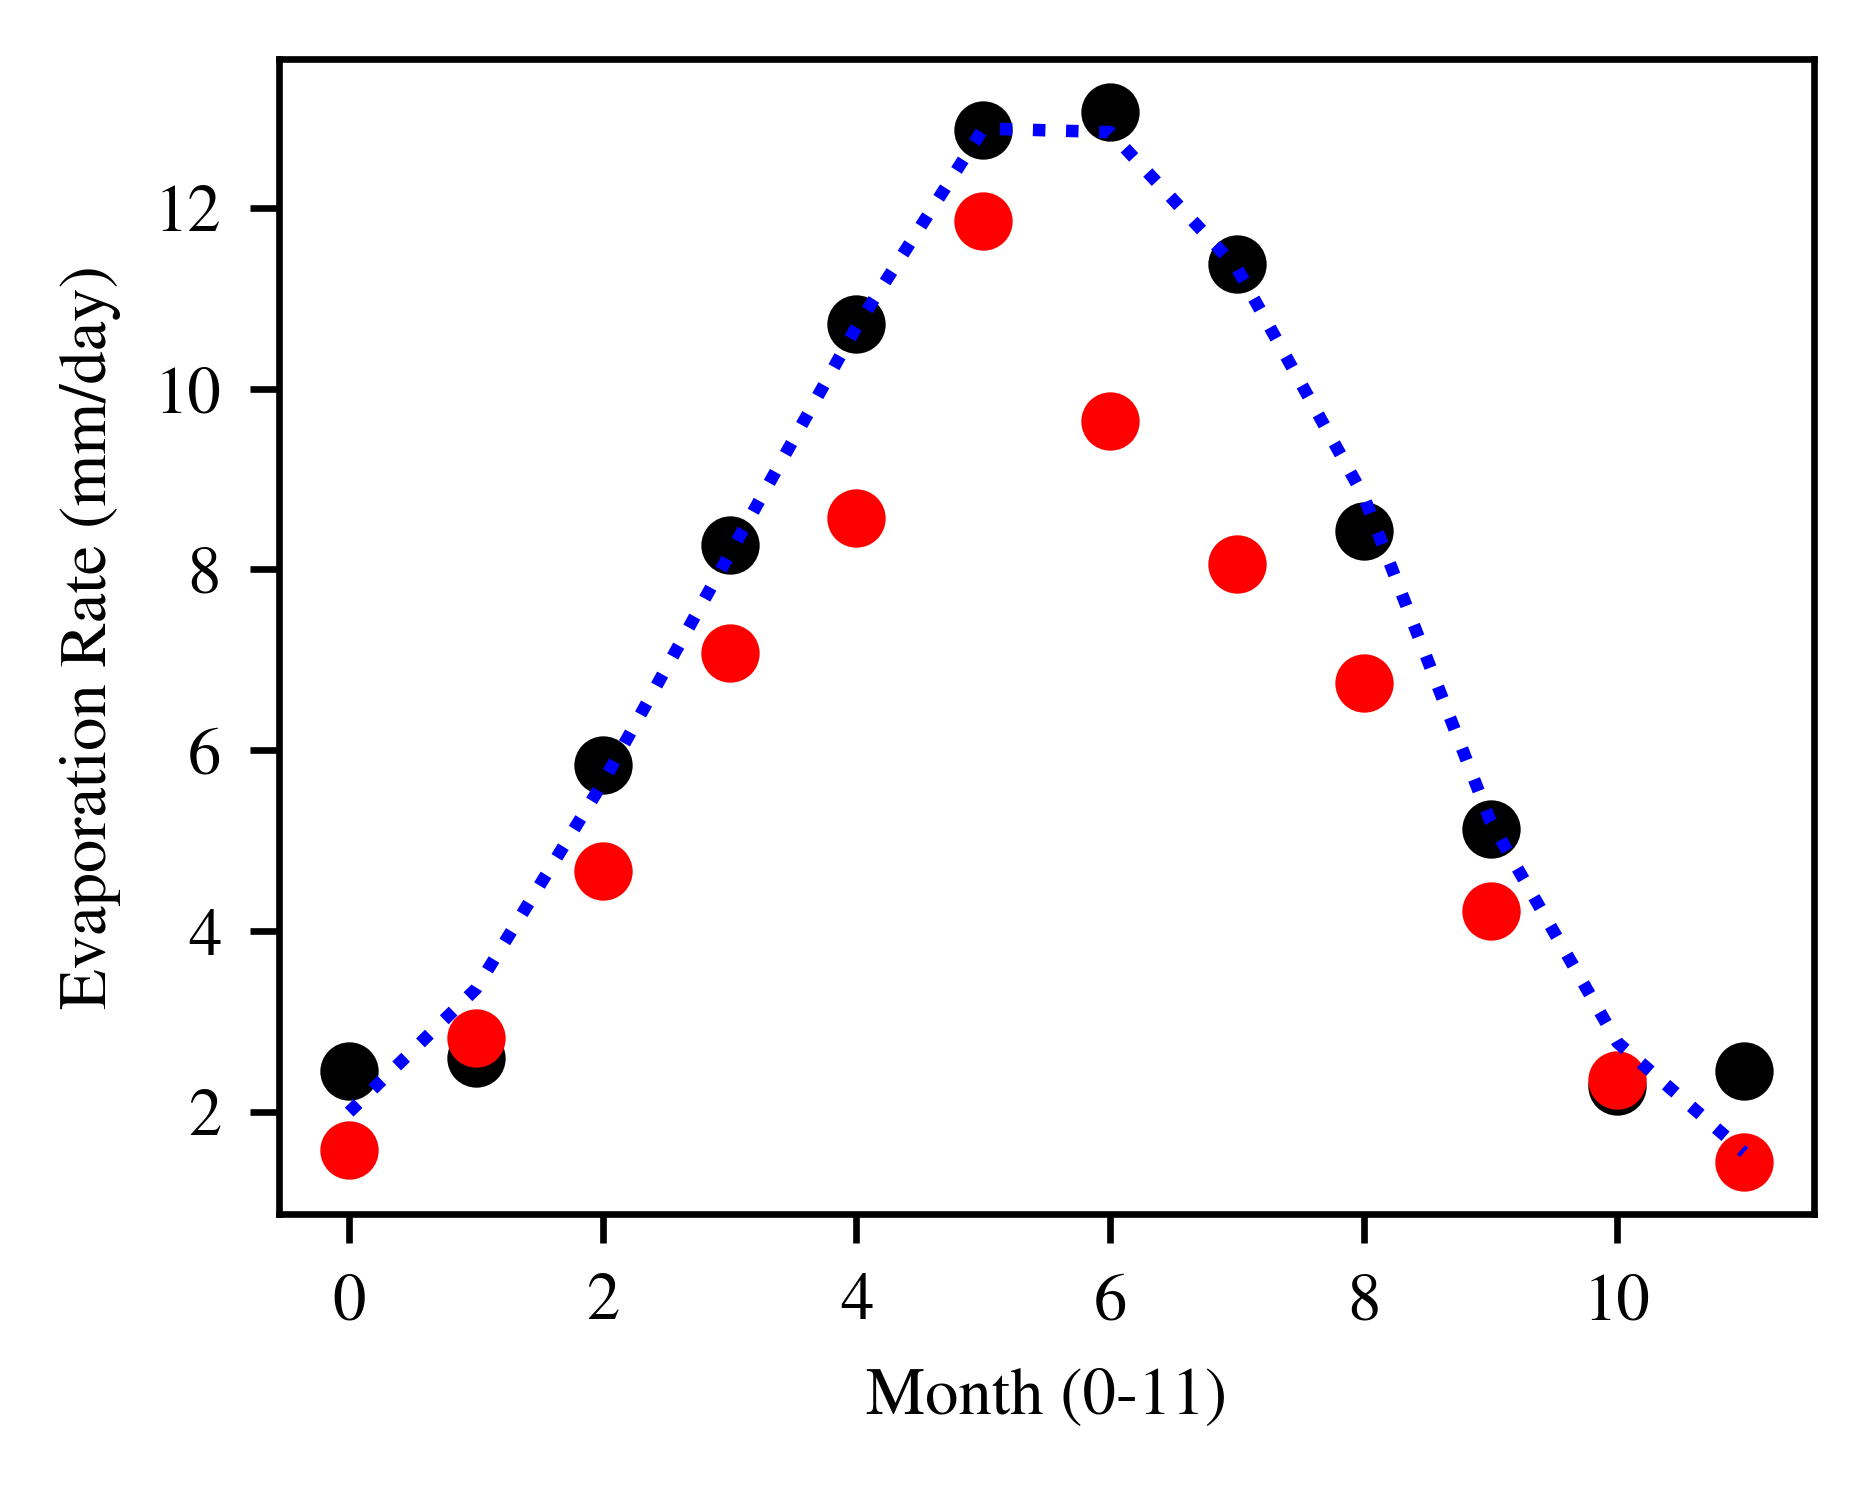

In [9]:
# Averaged monthly reservoir data
res_m_data = (
    res_m_df.groupby("month").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
)

pan_m_evap = pan_m_df.evap.to_numpy()
popt = utils.get_fit_parameters(res_m_data, pan_m_evap)

plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["evap"].to_numpy(), "o")  # Pan estimations
plt.plot(res_m_mean_df.to_numpy(), "o")  # Model predictions
plt.plot(
    pan_m_df["month"].to_numpy() - 1,
    utils.evaporation_rate_curve(res_m_data, *popt),
    "b",
)
plt.plot()

### Daily Interpolation


In [10]:
# Daily weather and solar data
pga_d_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps", "p01i"], "D")
irr_d_df = utils.get_mean(irr_df, "time", ["G(i)"], "D")

# Monthly reservoir data: weather and solar
res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

print(res_d_df.describe())

# Estimate average daily evaporation
d_evap = utils.evaporation_rate_curve(
    res_d_df.groupby(["month", "day"])
    .mean()[["tmpc", "dwpc", "G(i)", "smps"]]
    .to_numpy(),
    *popt
)
# Average daily precipitation
d_precip = (
    utils.get_sum(pga_df, "valid", ["p01i"], "D")
    .groupby(["month", "day"])
    .mean()["p01i"]
    .to_numpy()
)

print(d_evap.shape, d_precip.shape)

              tmpc         dwpc         smps      p01i         year  \
count  4571.000000  4571.000000  4571.000000    4571.0  4571.000000   
mean     15.939003    -1.689630     2.207147  0.002331  2013.792387   
std      10.276620     7.383473     1.356138    0.0132     4.200760   
min     -10.000000   -20.116667     0.000000       0.0  2005.000000   
25%       6.877083    -7.000000     1.328980       0.0  2010.000000   
50%      15.611110    -2.731481     2.014906       0.0  2014.000000   
75%      25.136210     2.841071     2.829442  0.000008  2017.000000   
max      40.611110    18.016667    12.861100  0.465025  2020.000000   

             month          day        G(i)  
count  4571.000000  4571.000000      4571.0  
mean      6.538175    15.635310  239.549118  
std       3.438745     8.792764    84.64286  
min       1.000000     1.000000   19.897917  
25%       4.000000     8.000000  161.856873  
50%       7.000000    16.000000  248.391251  
75%      10.000000    23.000000  310.9

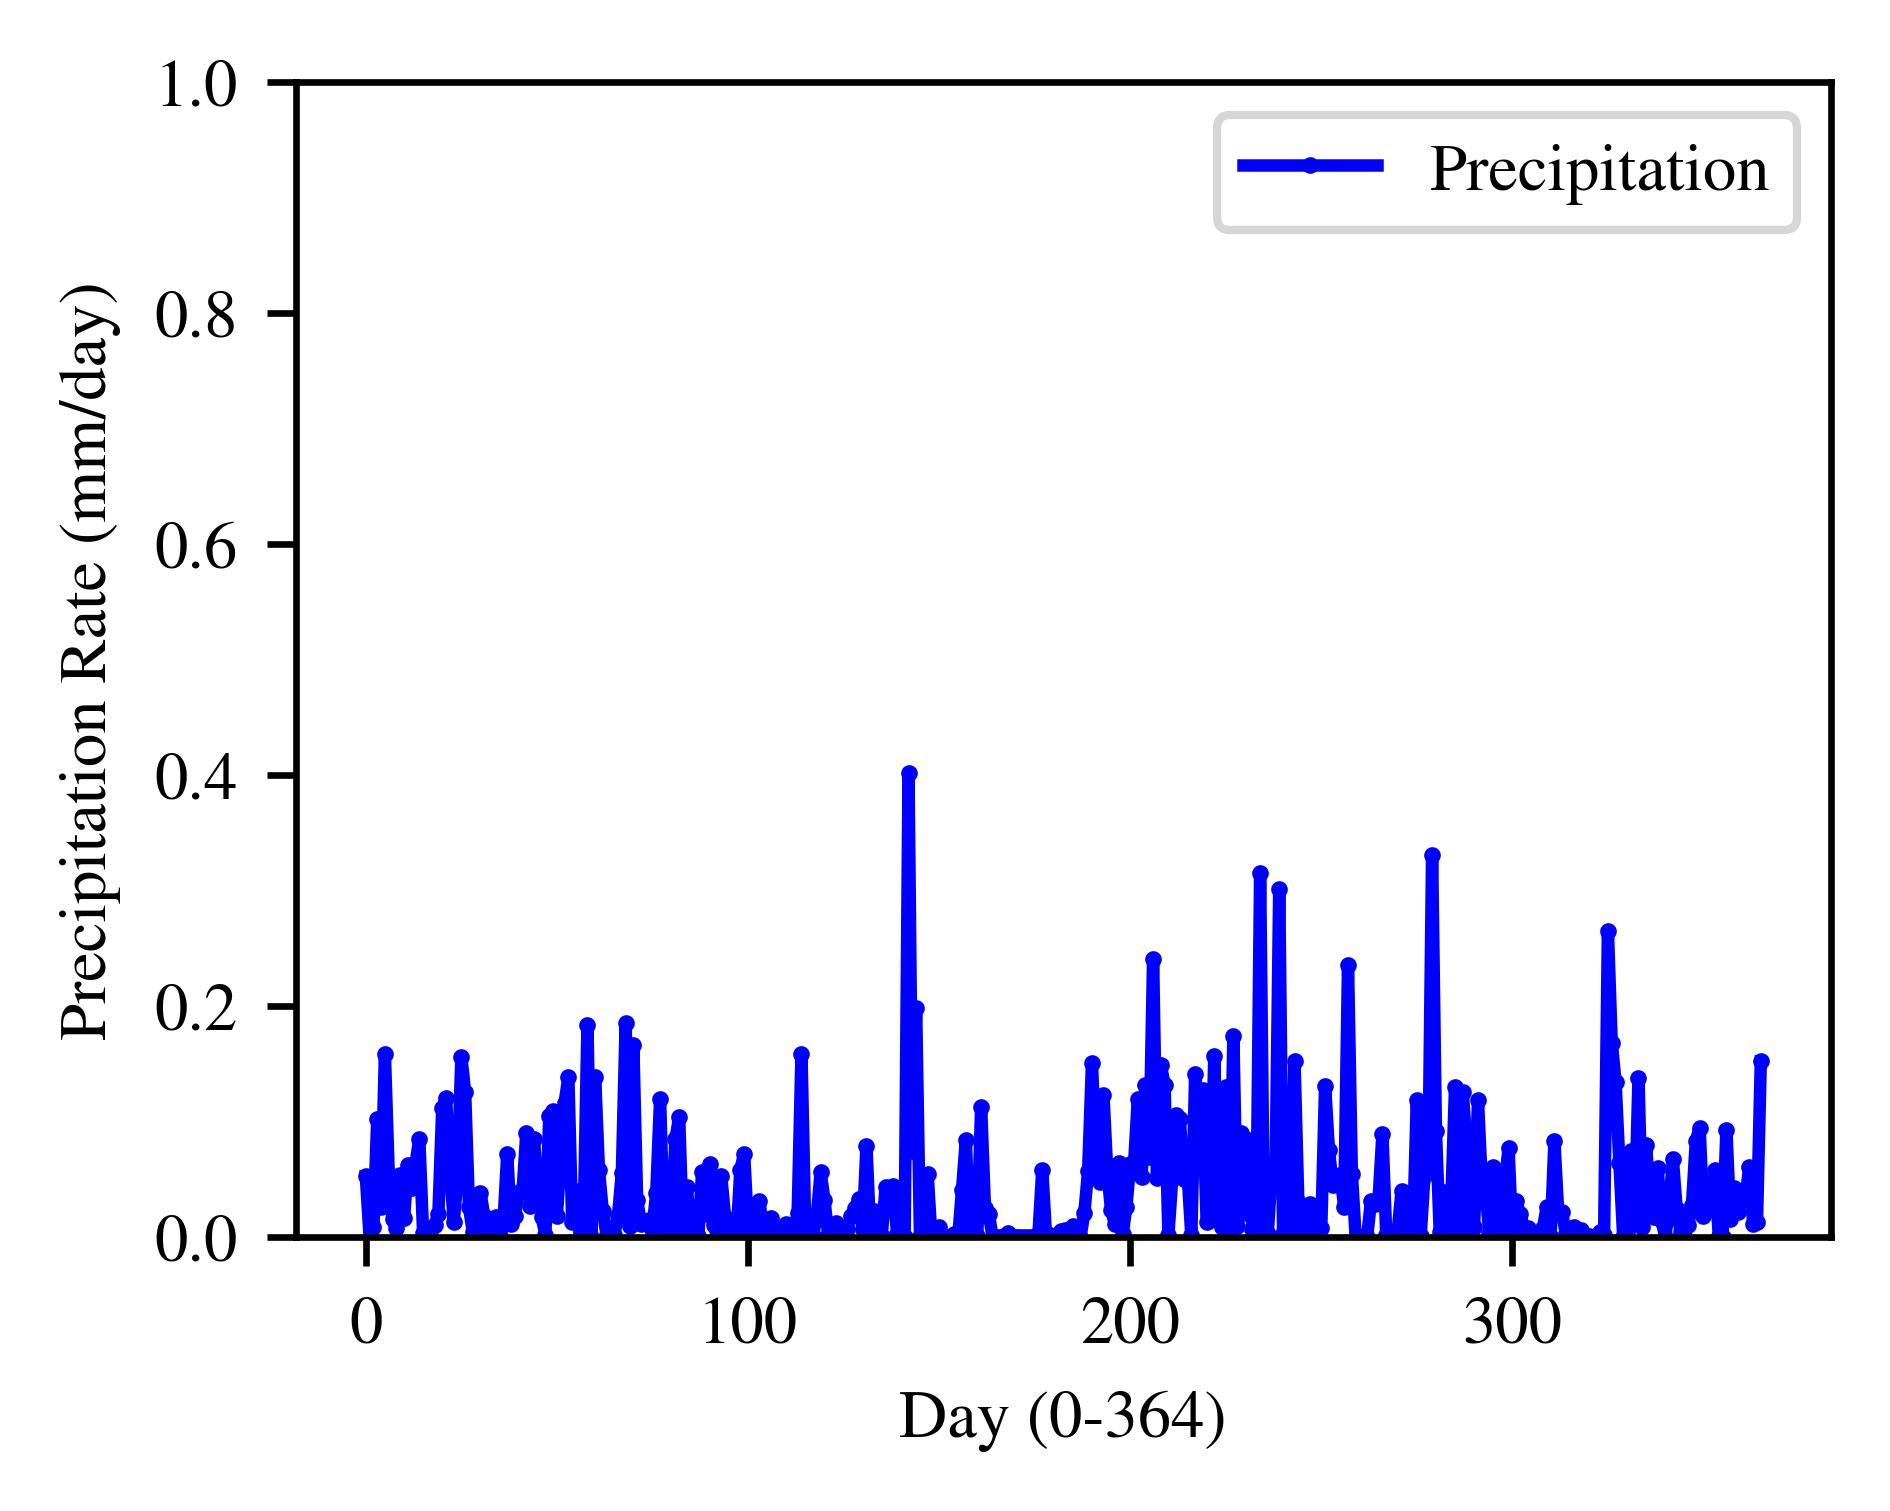

In [11]:
# d_evap[d_evap < 0] = 0
# d_precip[d_precip < 0] = 0

plt.figure()
plt.xlabel("Day (0-364)")
plt.ylabel("Precipitation Rate (mm/day)")
# plt.plot(d_evap, "-ro", label="Evaporation", markersize=1)  # Model predictions
plt.plot(d_precip, "-bo", label="Precipitation", markersize=1)  # Precipitation
plt.ylim(0, 1)
plt.legend()

or mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)


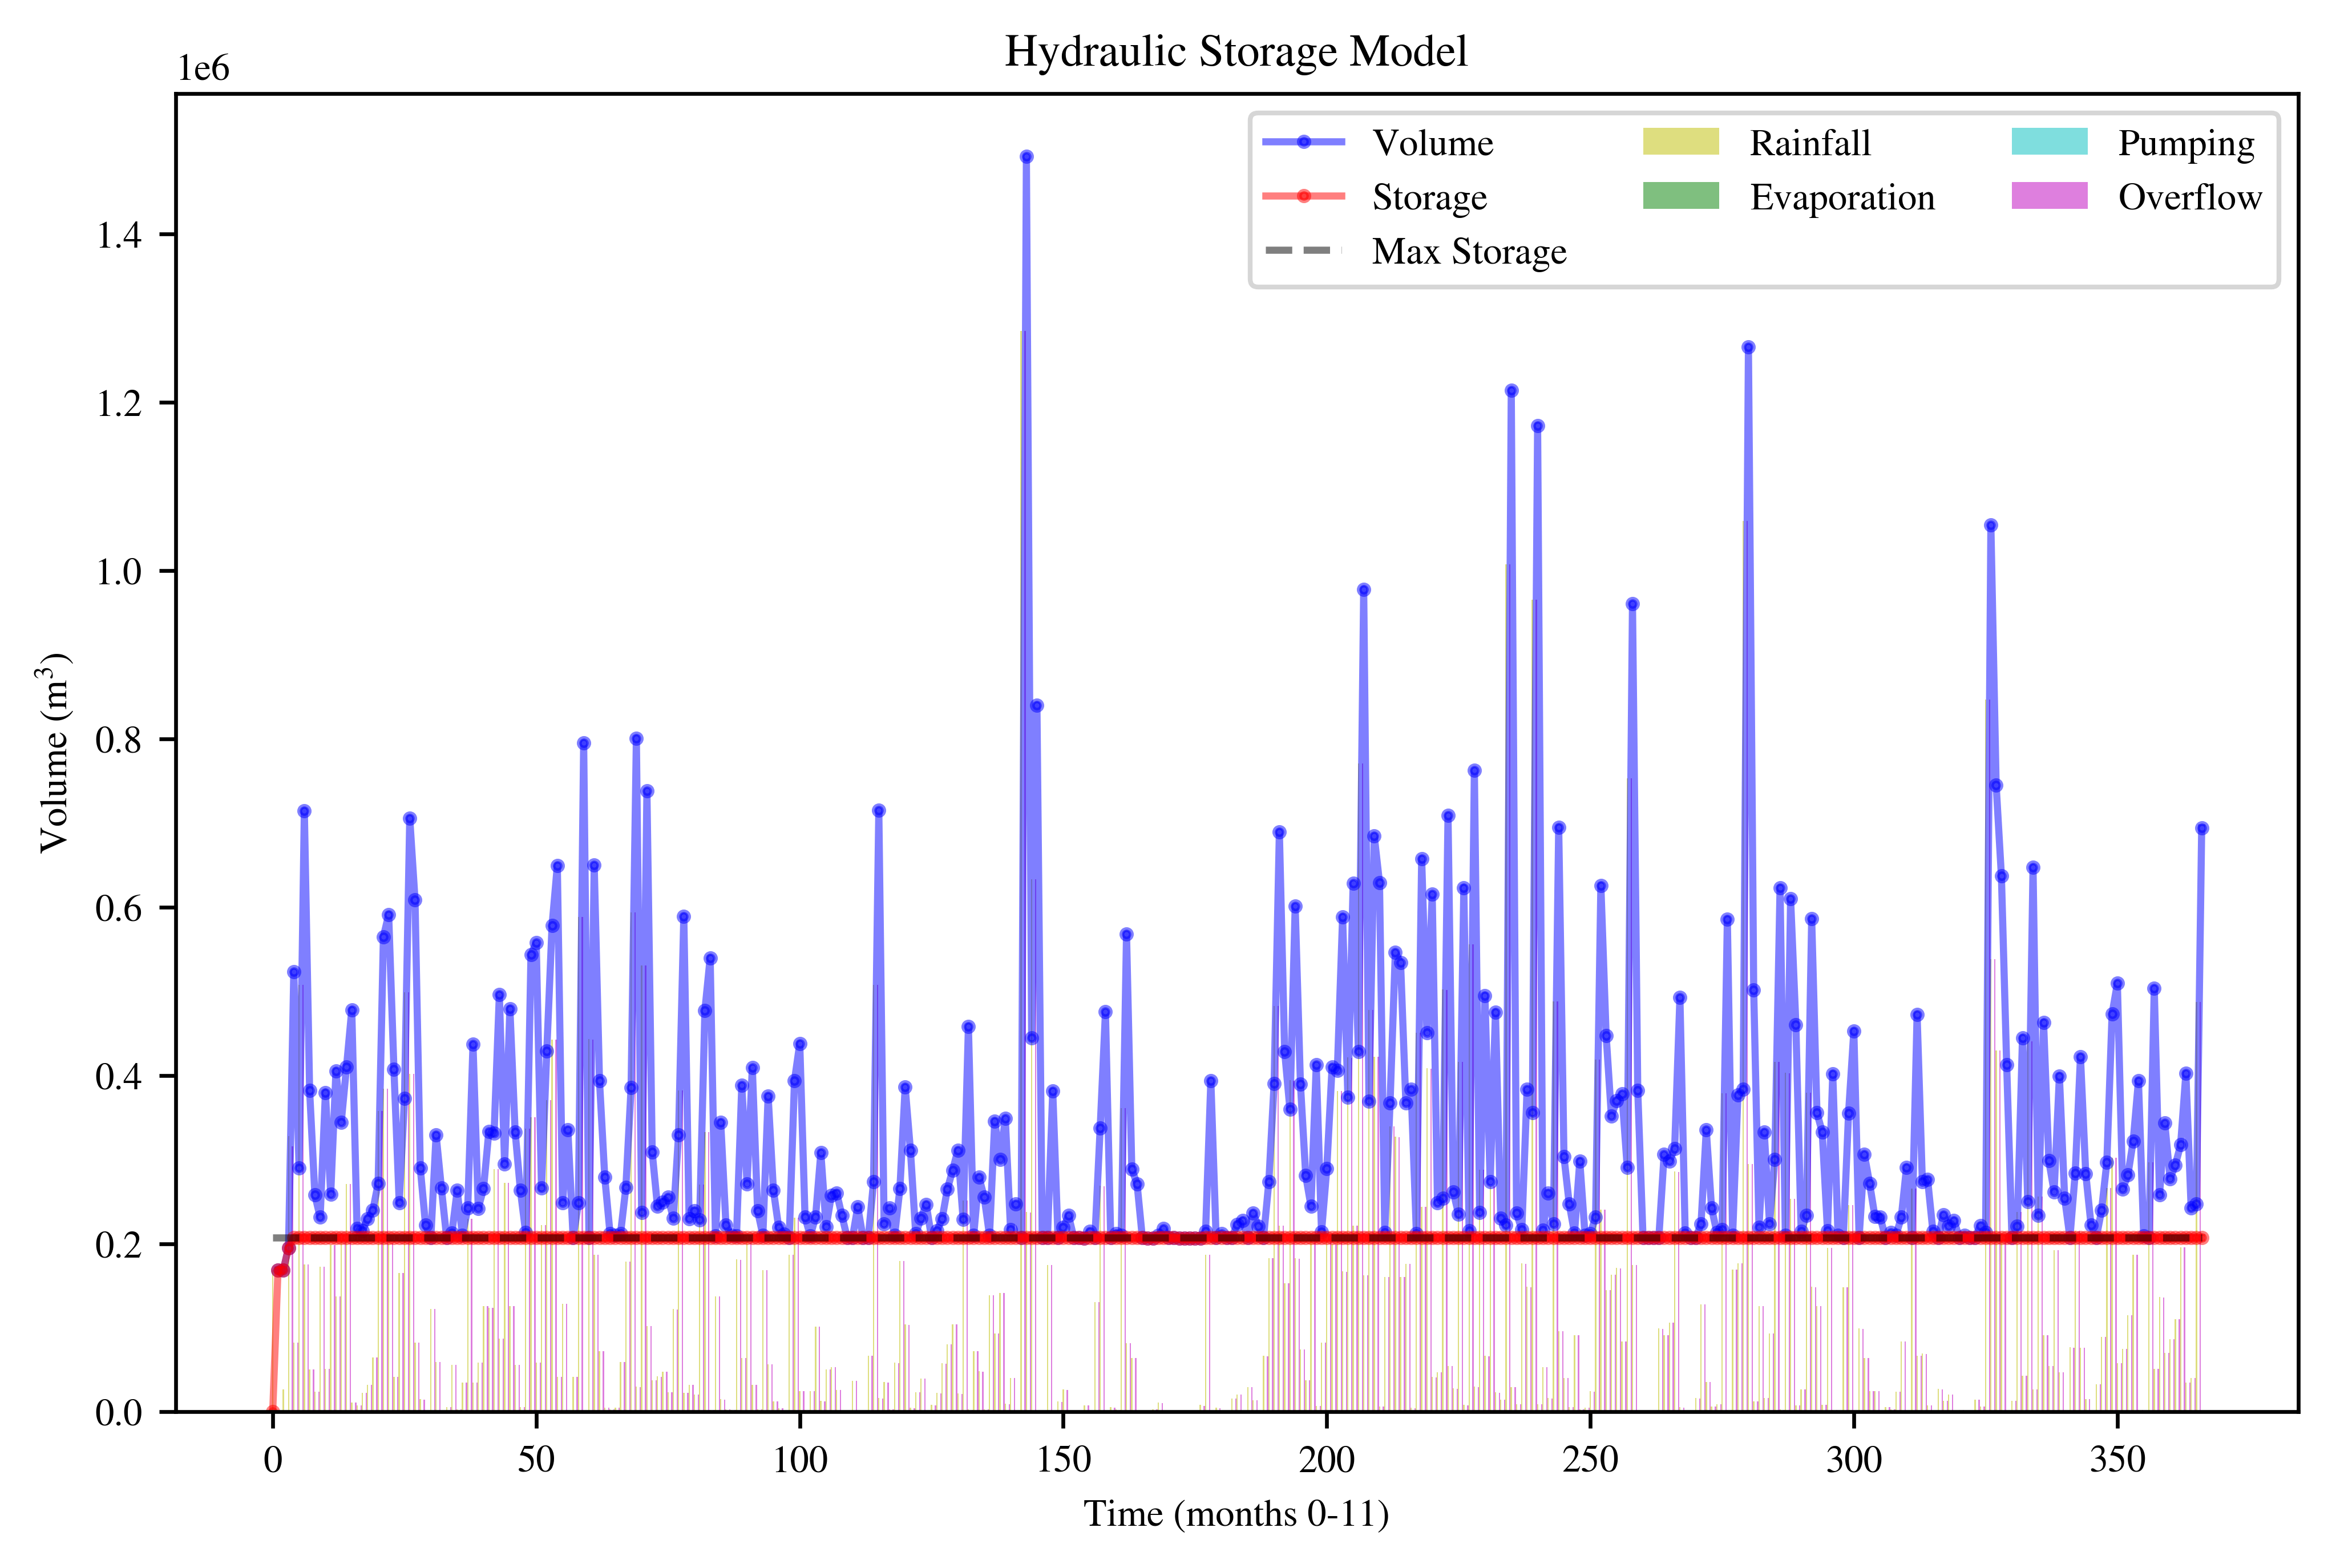

In [12]:
data = {
    None: {
        "num_periods": {None: d_evap.size},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": dict(enumerate(d_precip)),
        "E_pan": dict(
            enumerate(np.concatenate((np.repeat(PAN_EVAP_RATE / 30, 30), np.zeros(6))))
        ),
        # "E_pan": dict(enumerate(d_evap)),
        "E_coeff": {None: 0.8},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)

plot_model(instance)

or mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)


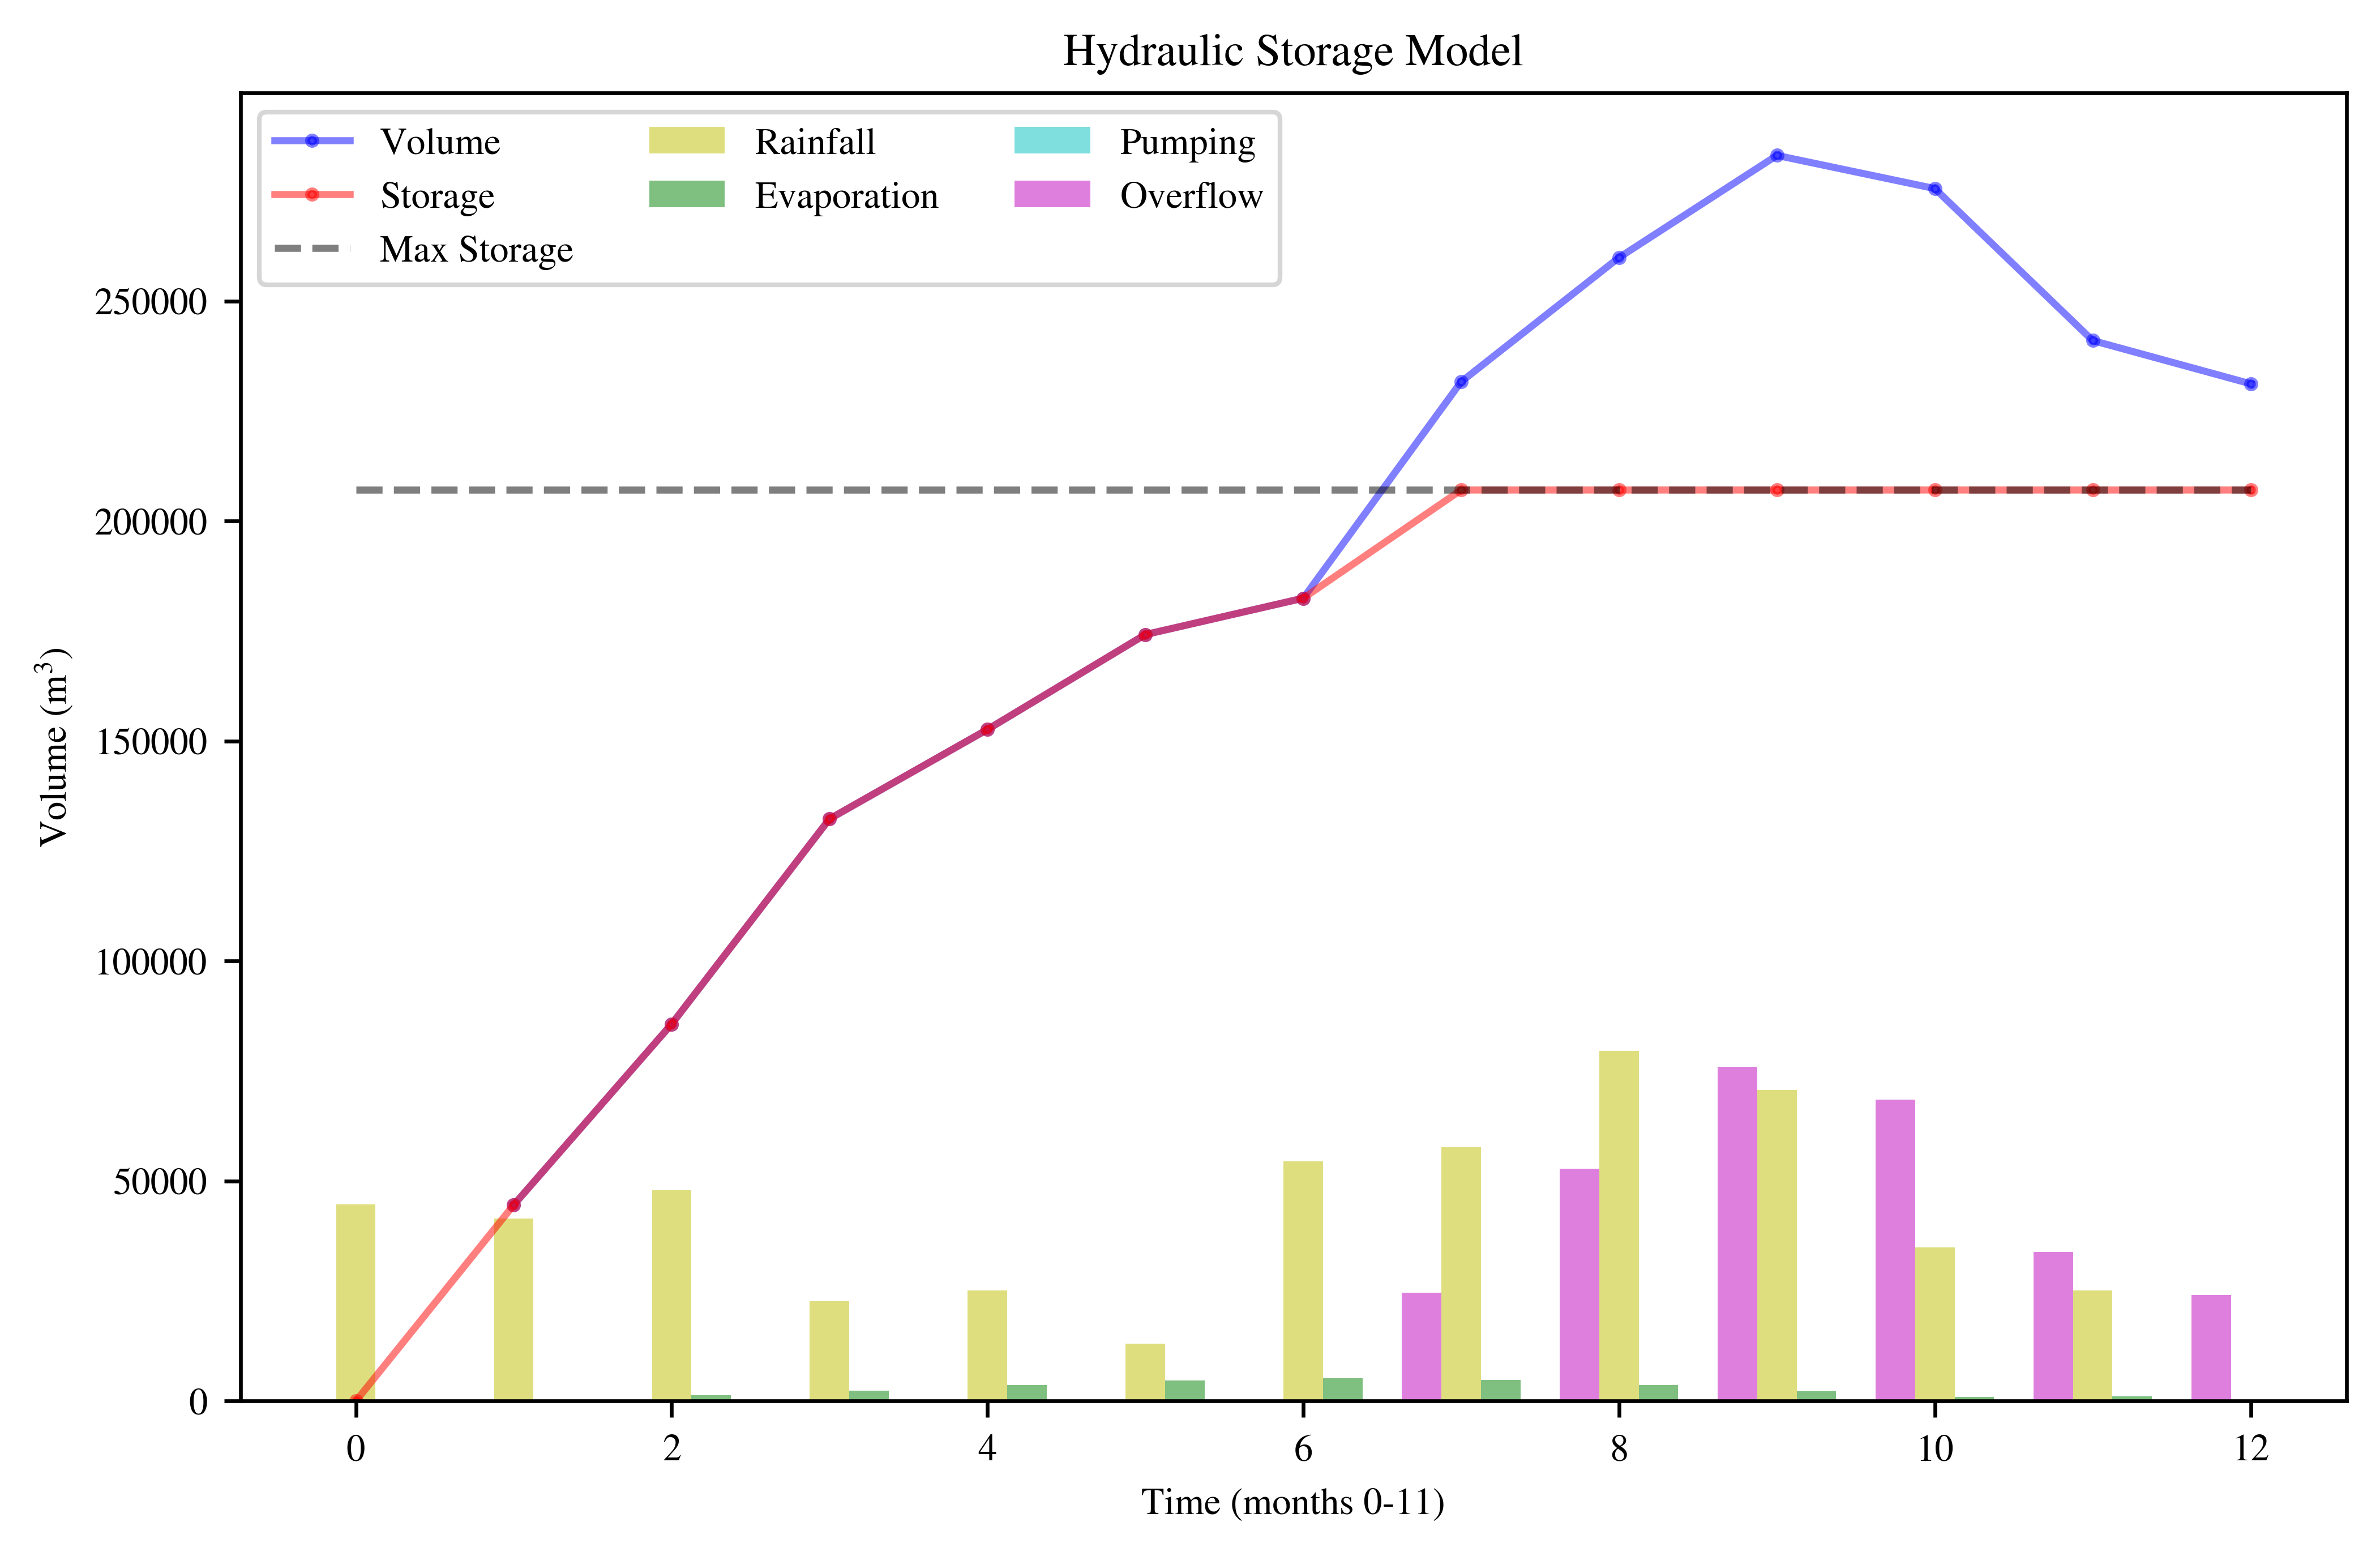

2 RangeSet Declarations
    T_periods : Dimen=1, Size=12, Bounds=(0, 11)
        Key  : Finite : Members
        None :   True :  [0:11]
    T_points : Dimen=1, Size=13, Bounds=(0, 12)
        Key  : Finite : Members
        None :   True :  [0:12]

11 Param Declarations
    A_c : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None : 3200000.0000000005
    A_max : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None : 21085
    E_coeff : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :   0.8
    E_pan : Size=12, Index=T_periods, Domain=NonNegativeReals, Default=None, Mutable=False
        Key : Value
          0 :              0.06223
          1 :              0.06604
          2 :             0.148336
          3 :  0.21005799999999997
          4 :  0.27228800000000003
          5 :             0.326644
          6 :         

In [62]:
data = {
    None: {
        "num_periods": {None: 12},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": dict(enumerate(PRECIP_RATE)),
        "E_pan": dict(enumerate(PAN_EVAP_RATE)),
        "E_coeff": {None: PAN_COEFF},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)

plot_model(instance)
instance.pprint()

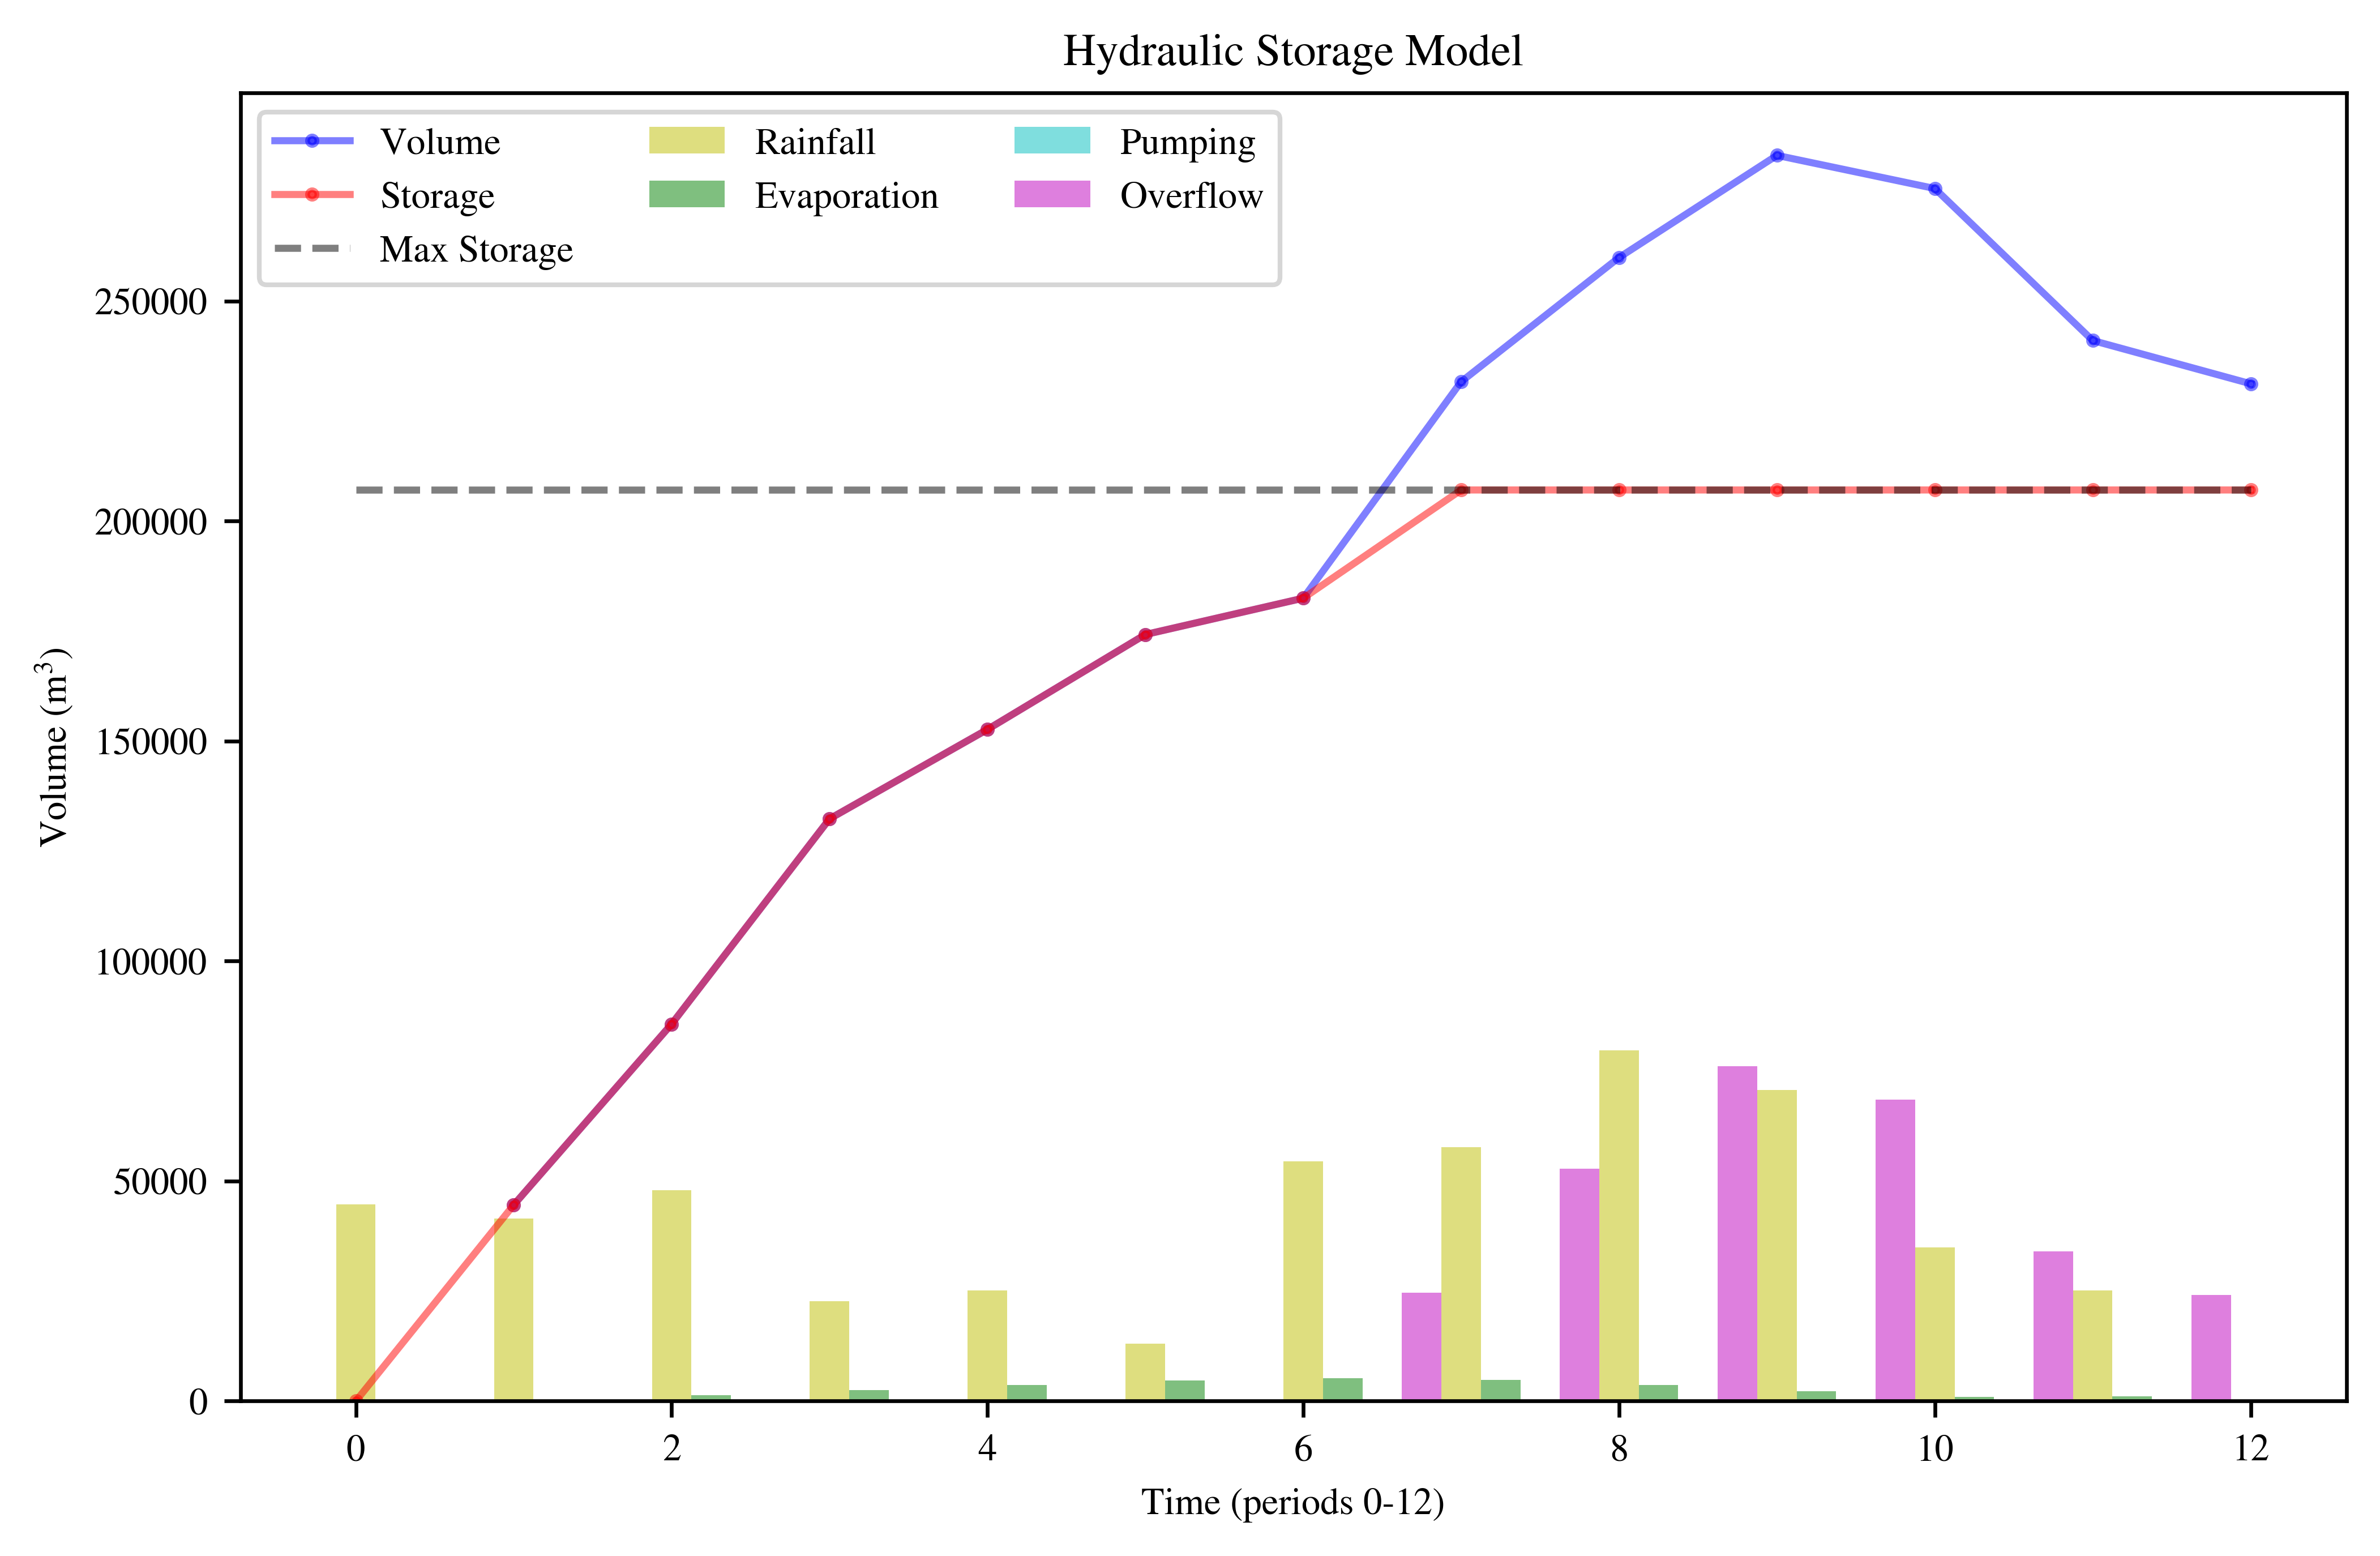

2 RangeSet Declarations
    K_periods : Dimen=1, Size=12, Bounds=(0, 11)
        Key  : Finite : Members
        None :   True :  [0:11]
    K_points : Dimen=1, Size=13, Bounds=(0, 12)
        Key  : Finite : Members
        None :   True :  [0:12]

6 Var Declarations
    A : Size=13, Index=K_points
        Key : Lower : Value                  : Upper : Fixed : Stale : Domain
          0 :     0 : -7.267533279851936e-10 :  None : False : False : NonNegativeReals
          1 :     0 :      4540.370957111917 :  None : False : False : NonNegativeReals
          2 :     0 :      8725.522172643323 :  None : False : False : NonNegativeReals
          3 :     0 :     13474.324493921074 :  None : False : False : NonNegativeReals
          4 :     0 :     15543.384688135824 :  None : False : False : NonNegativeReals
          5 :     0 :      17739.87668879657 :  None : False : False : NonNegativeReals
          6 :     0 :     18580.852262657307 :  None : False : False : NonNegativeReals
     

In [61]:
from importlib import reload
import reservoir_model

reload(reservoir_model)

cry = reservoir_model.ReservoirModel(
    solver=reservoir_model.Solver(),
    g1=C1,
    g2=C2,
    catchment_area=CATCHMENT_AREA,
    max_area=MAX_SURFACE_AREA,
    precip_rate=PRECIP_RATE,
    pan_evap_rate=PAN_EVAP_RATE,
    max_pump_rate=0,
)

cry.solve()
cry.plot()
cry.pprint()